In [1]:
import logging
import os
import functools
import datetime

from tqdm import tqdm

import numpy as np

import simulacra as si
import simulacra.units as u

import ionization as ion
import ionization.ide.delta_kicks as dk

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'PulseShape')
SIM_LIB = os.path.join(OUT_DIR, 'SIMLIB')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    fig_dpi_scale = 1.5,
)

%matplotlib inline

In [2]:
time_bound = 35
plot_bound = 3

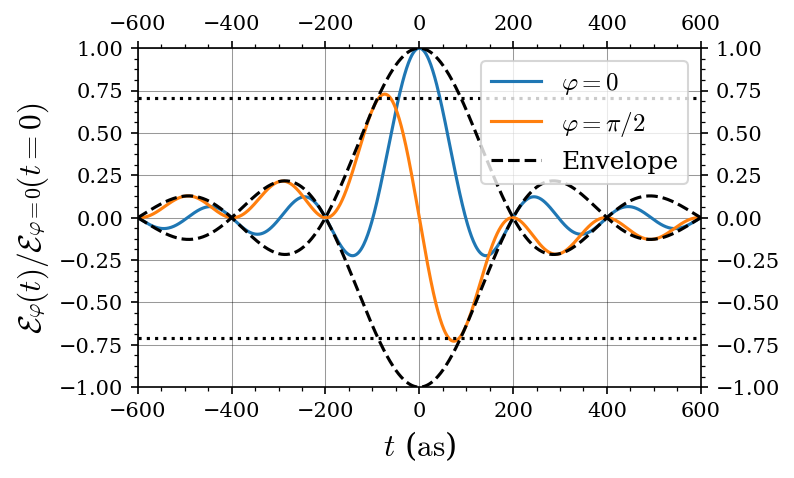

In [7]:
pw = 200 * u.asec
flu = 1 * u.Jcm2

times = np.linspace(-time_bound * pw, time_bound * pw, 10_000)

cos = ion.potentials.SincPulse(pulse_width = pw, fluence = flu)
sin = ion.potentials.SincPulse(pulse_width = pw, fluence = flu, phase = u.pi / 2)

si.vis.xy_plot(
    'cos_and_sin',
    times,
    cos.get_electric_field_amplitude(times) / cos.amplitude,
    sin.get_electric_field_amplitude(times) / cos.amplitude,
    cos.get_electric_field_envelope(times),
    -cos.get_electric_field_envelope(times),
    line_labels = [
        r'$\varphi = 0$',
        r'$\varphi = \pi / 2$',
        'Envelope',
        None,
    ],
    line_kwargs = [
        None,
        None,
        {'linestyle': '--', 'color': 'black'},
        {'linestyle': '--', 'color': 'black'},
    ],
    hlines = [
        1 / np.sqrt(2),
        -1 / np.sqrt(2),
    ],
    hline_kwargs = [
        {'linestyle': ':', 'color': 'black'},
        {'linestyle': ':', 'color': 'black'},
    ],
    x_unit = 'asec',
    x_label = r'$t$',
    y_label = r'$\mathcal{E_{\varphi}}(t) / \mathcal{E_{\varphi = 0}}(t=0) $',
    x_lower_limit = -plot_bound * pw,
    x_upper_limit = plot_bound * pw,
    **PLOT_KWARGS,
)

In [23]:
cos_corrected = ion.potentials.DC_correct_electric_potential(cos, times)
print(cos_corrected.info())

PotentialEnergySum
├─ SincPulse
│  ├─ Pulse Width: 200 as | 0.2 fs | 8.268 a.u.
│  ├─ Pulse Center: 0 as | 0 fs | 0 a.u.
│  ├─ Electric Field Amplitude Prefactor: 0.377 a.u. | 1.941e+11 V/m
│  ├─ Fluence: 1 J/cm^2
│  ├─ Carrier-Envelope Phase: 0 𝜋 rad | 0 deg
│  ├─ Carrier Photon Energy: 10.46 eV | 0.769 Rydberg | 0.385 Hartree
│  ├─ Photon Energy Range: 0.124 eV to 20.802 eV
│  ├─ Photon Energy Bandwidth: 20.68 eV | 1.52 Rydberg | 0.76 Hartree
│  ├─ Carrier Frequency: 2530 THz
│  ├─ Frequency Range: 30.0 THz to 5030.0 THz
│  ├─ Frequency Bandwidth: 5000 THz
│  ├─ Keldysh Parameter (hydrogen ground state): 1.018 (Carrier) | 2.013 (Bandwidth)
│  └─ NoTimeWindow
└─ Rectangle
   ├─ Amplitude: -0.001 a.u. | -3.277e+08 V/m
   ├─ Start Time: -7000 as | -7 fs | -289.4 a.u.
   ├─ End Time: 7000 as | 7 fs | 289.4 a.u.
   └─ NoTimeWindow


We're adding an electric field with an amplitude of about a thousand of an atomic electric field, which is flat across the main body of the pulse. This is about one six-hundredth of the amplitude near the center of the pulse.

In [33]:
print(np.abs(cos.amplitude / cos_corrected[1].amplitude))
r = np.abs(cos_corrected[1].amplitude / cos.amplitude)
print(r)

592.220835093
0.00168855930211


In [35]:
cos.get_electric_field_envelope(30.5 * pw)

0.010436389710943957

The envelope at $30\tau$ is about $.01$, so the extra electric field is about a tenth of the amplitude out there. But the field overall is so small out there that nothing is happening anyway.

In [13]:
print('cosine', cos.get_fluence_numeric(times) / u.Jcm2)
print('sine', cos.get_fluence_numeric(times) / u.Jcm2)
print('DC corrected cosine', cos_corrected.get_fluence_numeric(times) / u.Jcm2)
print('DC corrected cosine / cosine', cos_corrected.get_fluence_numeric(times) / cos.get_fluence_numeric(times))

cosine 0.996746920325
sine 0.996746920325
DC corrected cosine 0.997146092877
DC corrected cosine / cosine 1.00040047533


So the fluence changes by about 4 hundredths of a percent.